/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.6553 - loss: 0.6372 - precision: 0.6238 - recall: 0.8619 - val_accuracy: 0.8688 - val_loss: 0.3306 - val_precision: 0.9096 - val_recall: 0.8153
Epoch 2/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.8949 - loss: 0.2859 - precision: 0.8935 - recall: 0.8972 - val_accuracy: 0.8766 - val_loss: 0.3096 - val_precision: 0.8617 - val_recall: 0.8935
Epoch 3/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.9163 - loss: 0.2319 - precision: 0.9138 - recall: 0.9204 - val_accuracy: 0.8708 - val_loss: 0.3251 - val_precision: 0.8771 - val_recall: 0.8586
Epoch 4/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.9421 - loss: 0.1790 - precision: 0.9407 - recall: 0.9427 - val_accuracy: 0.8688 - val_loss: 0.3427 - val_precision: 0.8512 - val_recall: 0.8898
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8656 - loss: 0.3552 - precision: 0.8444 - recall: 0.8913
Test Accuracy: 0.8673
Precision: 0.8501
Re

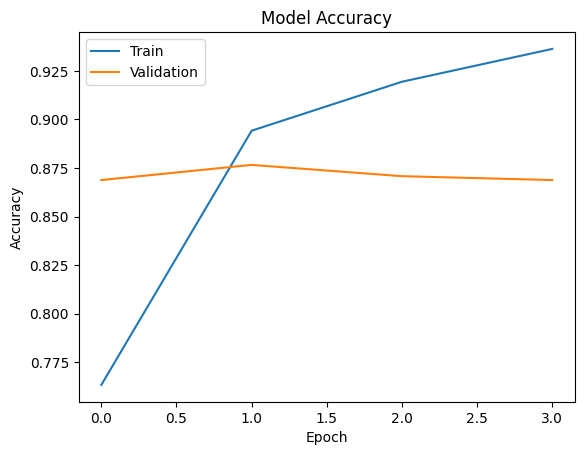

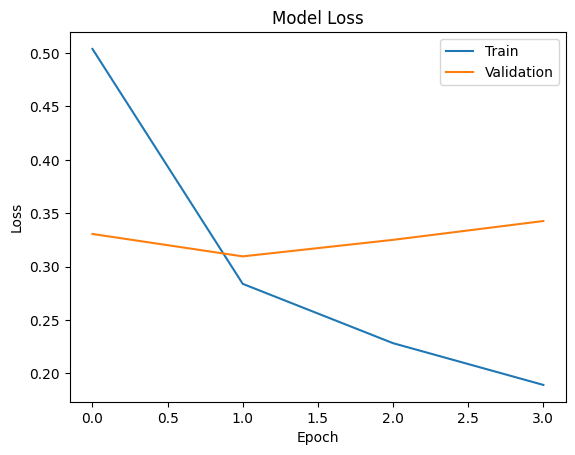

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted Sentiment: Negative


In [6]:
# Safe runnable version with one-hot encoding (reduced sizes to avoid OOM)
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Lambda, InputLayer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt

# ------------------------
# CHANGE for safety / demo
# ------------------------
max_features = 5000   # REDUCED from 20000 -> 5000 to avoid huge one-hot tensors
maxlen = 200          # REDUCED from 600 -> 200 to avoid huge sequences
# ------------------------

# Load dataset (only top `max_features` words)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Pad sequences to fixed length
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

# Build model
model = Sequential()

# Explicit input layer so Keras can infer shapes correctly
model.add(InputLayer(input_shape=(maxlen,), dtype='int32'))  # CHANGE: ensure input shape known

# One-hot encoding layer (turn tokens into one-hot vectors depth=max_features)
model.add(Lambda(lambda x: tf.one_hot(tf.cast(x, tf.int32), depth=max_features)))
# After this layer: shape = (batch_size, maxlen, max_features)

# Bidirectional LSTM
model.add(Bidirectional(LSTM(64, return_sequences=False)))

# Regularization
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

# Output
model.add(Dense(1, activation='sigmoid'))

# Compile
learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name="precision"), Recall(name="recall")]
)

# Train (use a smaller batch size to reduce memory pressure)
history = model.fit(
    x_train,
    y_train,
    epochs=4,           # REDUCED epochs for demo
    batch_size=32,      # SMALLER batch to reduce memory usage
    validation_split=0.2
)

# Evaluate
test_loss, test_acc, test_precision, test_recall = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

# Plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Predict sample
sample_review = x_test[0]
sample_review_input = np.expand_dims(sample_review, axis=0)
prediction = model.predict(sample_review_input)[0][0]
print("Predicted Sentiment:", "Positive" if prediction > 0.5 else "Negative")
